# Omar Khader's PS1 Seam Carving Implementation

In [3]:
import numpy as np# numerical computing 
import matplotlib.pyplot as plt # plotting and visualization
from PIL import Image# image stuff
import os# file operations


In [4]:

## required functions
# First we need to calculate the energy map of an input image.
# To do this we compute the intensity gradient in both x and y directions.
# Sobel / Prewitt are 3x3 operators we convolve over the image to get gradients.
# Then we turn gradients into energy per pixel via magnitude = sqrt(gx^2 + gy^2).
# Bonus: we penalize borders so seams do not hug the edges.

# Edge penalty (no edge hugging)
def add_edge_penalty(energy, penalty_strength=10.0): ## we take in the energy map and we set teh penalty strength 
  #bump up energy near borders so the algorithm avoids picking seams on sides.
  M, N = energy.shape ##store height width 
  edge_width = max(5, int(0.015 * min(M, N))) #set edge width with max 5 pixels 
  mean_energy = float(np.mean(energy)) or 1.0 #if mean energy is 0, set it to 1 base case
  x = np.arange(N); y = np.arange(M) #set x and y
  X, Y = np.meshgrid(x, y) #using np.meshgrid to create a grid for X and Y
  dist_from_left   = X #for every pixel we want to find the following  # distance to left edge = column index itself
  dist_from_right  = N - 1 - X # right edge is at N-1, subtract X to get how far from right side
  dist_from_top    = Y #distance to top edge = row index itself
  dist_from_bottom = M - 1 - Y #bottom edge is M-1, remove Y to get distance from the bottom
  dist_from_edge = np.minimum(np.minimum(dist_from_left, dist_from_right), np.minimum(dist_from_top,  dist_from_bottom)) ##use three np.minimums for 3 items 
  penalty_map = np.zeros_like(energy, dtype=np.float64) ##setting var panalty map as array size energy filled with zeros to get ready 
  mask = dist_from_edge < edge_width ##if dist from edge is less than edge width
  alpha = 3.0 / edge_width ##set alpha
  penalty_map[mask] = penalty_strength * mean_energy * np.exp(-alpha * dist_from_edge[mask])## apply the penalty to all pixels inside the mask: 
  return energy.astype(np.float64) + penalty_map  # convert to float for precision and add penalty map on top of energy then return


# Simple gradient-based energy using numpy.gradient
def find_energy(image):
  #1 must be RGB MxNx3
  assert image.ndim == 3 and image.shape[2] == 3
  #2 float from 0 to 1
  imf = image.astype(np.float64) / 255.0
  #3 grayscale  standard luminance formula from pdf
  grey = 0.299*imf[...,0] + 0.587*imf[...,1] + 0.114*imf[...,2]
  #4 gradients in x and y
  gy, gx = np.gradient(grey)
  energy = np.sqrt(gx*gx + gy*gy)
  #5 edge penalty (bonus)
  energy = add_edge_penalty(energy, penalty_strength=10.0)
  return energy.astype(np.float64)

# Manual SAME convolution with reflect padding
def _pad_reflect(img, ph, pw): 
    return np.pad(img, ((ph, ph), (pw, pw)), mode='reflect')  # pad image with reflected edges (ph vertically, pw horizontally)

def _conv2d_same(gray, kernel):
  kh, kw = kernel.shape # kernel height and width
  ph, pw = kh//2, kw//2 #finding the padding needed on each side
  padded = _pad_reflect(gray, ph, pw)# pad using reflection to handle borders
  H, W = gray.shape #image dimensions
  out = np.zeros_like(gray, dtype=np.float64) # out array same size
  k = np.flipud(np.fliplr(kernel))#flip kernel both vertically and horizontally
  for i in range(H):   ##for each row 
    for j in range(W): #and each column
      patch = padded[i:i+kh, j:j+kw] ##find size of the patch 
      out[i, j] = np.sum(patch * k) # element-wise multiply as pixel value at row i, column j
  return out 

def find_energy_sobel(image): # make sure input is a color image 
  assert image.ndim == 3 and image.shape[2] == 3
  imf = image.astype(np.float64)/255.0 # normalize to [0,1] 
  grey = 0.299*imf[...,0] + 0.587*imf[...,1] + 0.114*imf[...,2] #luminance weights
  sobel_x = np.array([[-1,0,1],[-2,0,2],[-1,0,1]], dtype=np.float64) #kernel for x-direction
  sobel_y = np.array([[-1,-2,-1],[0,0,0],[1,2,1]], dtype=np.float64)#kernel for y-direction
  gx = _conv2d_same(grey, sobel_x)# call _conv2d_same to do convolution on x
  gy = _conv2d_same(grey, sobel_y) #same for y 
  energy = np.sqrt(gx*gx + gy*gy) #compute energy as sqrt of gx^2 + gy^2
  energy = add_edge_penalty(energy, penalty_strength=10.0) #add edge penalty
  return energy.astype(np.float64) #return as the new updated eneergy with the penalty calculate higher energy 

def find_energy_prewitt(image): ##same as find_energy_sobel but we are using differnet filters 
  assert image.ndim == 3 and image.shape[2] == 3
  imf = image.astype(np.float64)/255.0
  grey = 0.299*imf[...,0] + 0.587*imf[...,1] + 0.114*imf[...,2]
  prewitt_x = np.array([[-1,0,1],[-1,0,1],[-1,0,1]], dtype=np.float64) ##different filters in x and y than sobel 
  prewitt_y = np.array([[-1,-1,-1],[0,0,0],[1,1,1]], dtype=np.float64)
  gx = _conv2d_same(grey, prewitt_x)
  gy = _conv2d_same(grey, prewitt_y)
  energy = np.sqrt(gx*gx + gy*gy)
  energy = add_edge_penalty(energy, penalty_strength=10.0)
  return energy.astype(np.float64) ##return updated energy

# Dynamic Programming cumulative map (paper)
def Cumulative_min_energy_map(energyImg, SD):
  assert energyImg.ndim == 2  # make sure it's a 2D grayscale energy image
  dir_up = SD.upper() #we know direction string is uppercase
  if dir_up == 'VERTICAL':
    M, N = energyImg.shape #(rows=M, cols=N)
    Cumulative = np.zeros_like(energyImg, dtype=np.float64)# cumulative energy map
    Cumulative[0] = energyImg[0]  #first row = same as energy because first row has no pixels above it
    for i in range(1, M): # go row by row
      left  = np.r_[np.inf, Cumulative[i-1, :-1]] #shift previous row right
      up    = Cumulative[i-1] #straight above
      right = np.r_[Cumulative[i-1, 1:], np.inf] #shift previous row left
      best = np.minimum(np.minimum(left, up), right) #find min of left, up, right
      Cumulative[i] = energyImg[i] + best #add current energy to best from above
    return Cumulative #return cumulative
  
  if dir_up == 'HORIZONTAL':
    return Cumulative_min_energy_map(energyImg.T, 'VERTICAL').T
  raise ValueError("Direction must be 'VERTICAL' or 'HORIZONTAL'")

def find_vertical_seam(CumulativeEnergyMap):
  M, N = CumulativeEnergyMap.shape ##get the height and width
  seam = np.zeros(M, dtype=np.int32) ##initialize the seam array 
  seam[-1] = int(np.argmin(CumulativeEnergyMap[-1])) ##find the min of the last row
  for i in range(M-2, -1, -1):  # move upward from 2nd-to-last row to top
    j = seam[i+1] ## col index chosen in the row below
    j_left = max(j-1, 0) ## clamp left boundary
    j_right = min(j+1, N-1)# # clamp right boundary 
    window = CumulativeEnergyMap[i, j_left:j_right+1] #all the possible parents in row above
    seam[i] = j_left + int(np.argmin(window)) ## pick best parent and store its col index
  return seam #the final seam path from top to bottom 

def find_horizontal_seam(CumulativeEnergyMap): 
  return find_vertical_seam(CumulativeEnergyMap.T).astype(np.int32) # transpose to reuse vertical seam, then cast back to int32

# actual carving in the x axis 
def decrease_width(image, energyImg_in):
    Cumulative = Cumulative_min_energy_map(energyImg_in, 'VERTICAL')   # build vertical cumulative map
    seam = find_vertical_seam(Cumulative)# find optimal vertical seam
    M, N, _ = image.shape # image dimensions
    out = np.zeros((M, N-1, 3), dtype=image.dtype)# output image (width - 1)
    for i in range(M):
        j = seam[i]# column index to remove
        out[i, :, :] = np.delete(image[i, :, :], j, axis=0)  # remove seam pixel at row i
    new_energy = None# placeholder for recomputed energy
    return out, new_energy

def decrease_height(image, energyImg_in):
    Cumulative = Cumulative_min_energy_map(energyImg_in, 'HORIZONTAL') # build horizontal cumulative map
    seam = find_horizontal_seam(Cumulative)       # find optimal horizontal seam
    M, N, _ = image.shape # image dimensions
    out = np.zeros((M-1, N, 3), dtype=image.dtype)# output image (height - 1)
    for j in range(N):
        i = seam[j]# row index to remove
        out[:, j, :] = np.delete(image[:, j, :], i, axis=0)  # remove seam pixel at col j
    new_energy = None# placeholder for recomputed energy
    return out, new_energy

def view_seam(im, seam, seamDirection):
    dir_up = seamDirection.upper()# normalize seam direction
    plt.imshow(im)        # show image
    if dir_up == 'VERTICAL':
        plt.plot(seam, np.arange(len(seam)), 'r-')# plot vertical seam in red
    elif dir_up == 'HORIZONTAL':
        plt.plot(np.arange(len(seam)), seam, 'b-')# plot horizontal seam in blue
    else:
        raise ValueError("Direction must be 'VERTICAL' or 'HORIZONTAL'") # invalid direction
    plt.axis('off'); plt.show() # hide axes and display

# Alt helpers for Task 5
def _pad_reflect_local(arr, ph, pw):
    return np.pad(arr, ((ph, ph), (pw, pw)), mode='reflect')# reflect padding for borders

def conv2d_same(gray, kernel):
    kh, kw = kernel.shape # kernel dimensions
    ph, pw = kh//2, kw//2 # padding amounts
    padded = _pad_reflect_local(gray, ph, pw)# reflect pad input
    out = np.zeros_like(gray, dtype=np.float64)   # output array
    for i in range(gray.shape[0]):
        for j in range(gray.shape[1]):
            window = padded[i:i+kh, j:j+kw]# local region same size as kernel
            out[i, j] = float(np.sum(window * kernel))# convolution = elementwise sum
    return out

def energy_img_prewitt_custom(im, w_vert=1.25, w_horz=1.0, apply_edge_penalty=True):
    if im.dtype != np.uint8 or im.ndim != 3 or im.shape[2] != 3:      
        raise ValueError('im must be MxNx3 uint8') # sanity check on input
    imf = im.astype(np.float64)/255.0# normalize to [0,1]
    gray = 0.299*imf[...,0] + 0.587*imf[...,1] + 0.114*imf[...,2]# grayscale conversion
    kx = np.array([[-1,0,1],[-1,0,1],[-1,0,1]], dtype=np.float64)# Prewitt kernel X
    ky = np.array([[-1,-1,-1],[0,0,0],[1,1,1]], dtype=np.float64)# Prewitt kernel Y
    gx = conv2d_same(gray, kx)# gradient in x
    gy = conv2d_same(gray, ky)# gradient in y
    energy = np.hypot(w_vert*gx, w_horz*gy)# weighted gradient magnitude
    if apply_edge_penalty:
        energy = add_edge_penalty(energy, penalty_strength=10.0)# optional edge penalty
    return energy.astype(np.float64)

def cumulative_min_energy_map_local(energyImg, seamDirection):
    seamDirection = seamDirection.upper()   # normalize direction
    M, N = energyImg.shape    # dimensions
    cu = energyImg.astype(np.float64).copy()#  copy into cu float
    if seamDirection == 'VERTICAL':
        for i in range(1, M):
            prev = cu[i-1]# row above
            for j in range(N):
                m = prev[j]   # straight above
                if j > 0: m = min(m, prev[j-1])   # check above-left
                if j < N-1: m = min(m, prev[j+1]) # check above-right
                cu[i, j] += m # accumulate min energy
    elif seamDirection == 'HORIZONTAL':
        for j in range(1, N):
            prev = cu[:, j-1] # col to the left
            for i in range(M):
                m = prev[i]   # directly left
                if i > 0: m = min(m, prev[i-1])   # check above-left
                if i < M-1: m = min(m, prev[i+1]) # check below-left
                cu[i, j] += m # accumulate min energy
    else:
        raise ValueError("seamDirection must be 'VERTICAL' or 'HORIZONTAL'")
    return cu

def _find_vertical_seam_from(cum):
    M, N = cum.shape
    seam = np.zeros(M, dtype=np.int64)# seam col indices
    seam[-1] = int(np.argmin(cum[-1]))# start bottom row
    for i in range(M-2, -1, -1):  # go upward
        j = seam[i+1]     # col below
        candidates = [j]  # straight up
        if j > 0: candidates.append(j-1)# up-left
        if j < N-1: candidates.append(j+1)# up-right
        seam[i] = min(candidates, key=lambda c: cum[i, c])# pick lowest energy parent
    return seam

def _find_horizontal_seam_from(cum):
    M, N = cum.shape
    seam = np.zeros(N, dtype=np.int64)# seam row indices
    seam[-1] = int(np.argmin(cum[:, -1]))         # start rightmost col
    for j in range(N-2, -1, -1):  # go leftward
        i = seam[j+1]     # row below
        candidates = [i]  # straight left
        if i > 0: candidates.append(i-1)# upper-left
        if i < M-1: candidates.append(i+1)# lower-left
        seam[j] = min(candidates, key=lambda r: cum[r, j])# pick lowest energy parent
    return seam

# Required-name wrappers and baseline
def energy_img(im):
    assert im.dtype == np.uint8 and im.ndim == 3 and im.shape[2] == 3 # input must be MxNx3 uint8
    imf = im.astype(np.float64)/255.0 #normalize to [0,1]
    gray = 0.299*imf[...,0] + 0.587*imf[...,1] + 0.114*imf[...,2]# grayscale
    gy, gx = np.gradient(gray)# gradients
    return np.hypot(gx, gy).astype(np.float64)# gradient magnitude

def cumulative_min_energy_map(energyImg, seamDirection):
    return Cumulative_min_energy_map(energyImg, seamDirection)# wrapper for main cumulative fn

def decrease_width_baseline(image, energyImg_in):
    out, _ = decrease_width(image, energyImg_in)  # carve width by 1
    new_energy = energy_img(out)  # recompute energy
    return out, new_energy

def decrease_height_baseline(image, energyImg_in):
    out, _ = decrease_height(image, energyImg_in) # carve height by 1
    new_energy = energy_img(out)  # recompute energy
    return out, new_energy



## Task 1 & 2 — Reduce width by 100 and height by 50 (Prague & Mall)

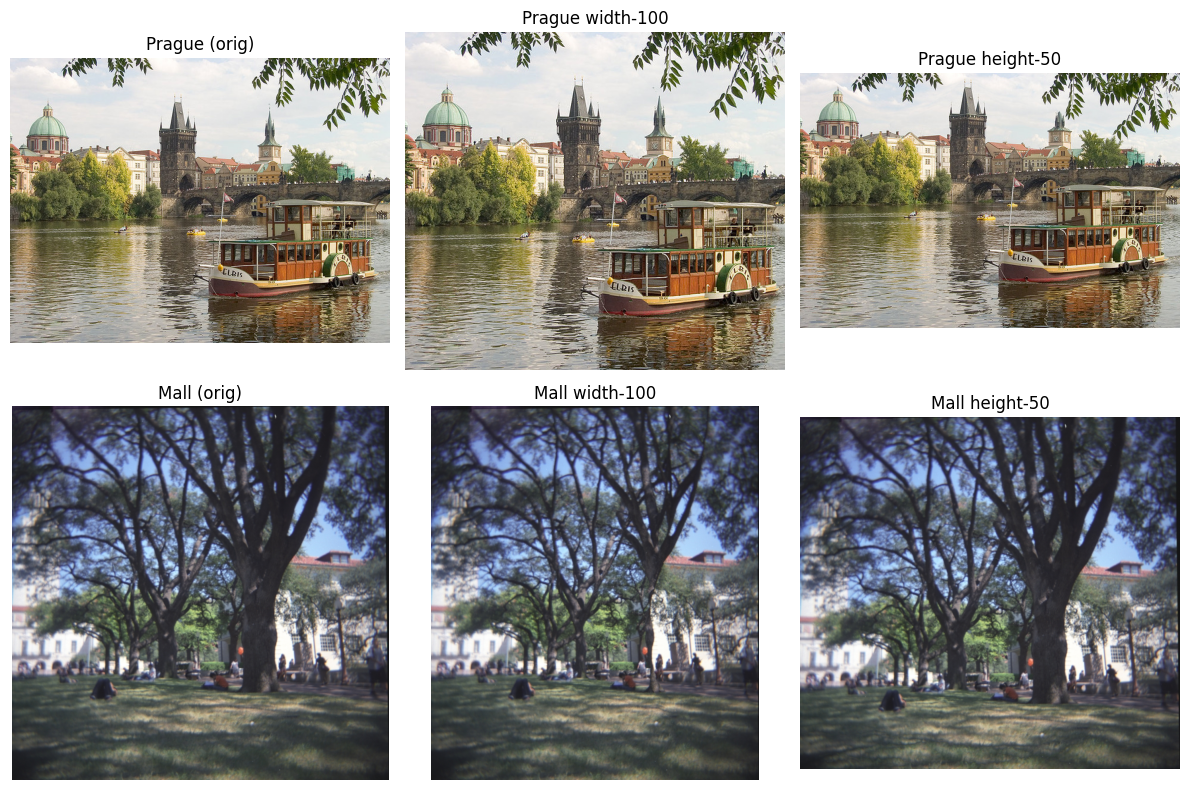

In [5]:
prague_path = 'inputSeamCarvingPrague.jpg'# input image path for Prague
mall_path   = 'inputSeamCarvingMall.jpg'# input image path for Mall
im_prague = np.array(Image.open(prague_path).convert('RGB'), dtype=np.uint8)  # load Prague image as RGB array
im_mall   = np.array(Image.open(mall_path).convert('RGB'),   dtype=np.uint8)  # load Mall image as RGB array

def reduce_width_by_100(im):
    energy = energy_img(im)# compute initial energy map
    out = im.copy()# copy input image
    for _ in range(100):# repeat 100 seam removals
        out, energy = decrease_width_baseline(out, energy)  # carve one vertical seam, update energy
    return out

def reduce_height_by_50(im):
    energy = energy_img(im)# compute initial energy map
    out = im.copy()# copy input image
    for _ in range(50):# repeat 50 seam removals
        out, energy = decrease_height_baseline(out, energy) # carve one horizontal seam, update energy
    return out

out_w_prague = reduce_width_by_100(im_prague)# Prague with 100 cols removed
out_h_prague = reduce_height_by_50(im_prague)# Prague with 50 rows removed
out_w_mall   = reduce_width_by_100(im_mall)  # Mall with 100 cols removed
out_h_mall   = reduce_height_by_50(im_mall)  # Mall with 50 rows removed

Image.fromarray(out_w_prague).save('outputReduceWidthPrague.png')# save Prague reduced width
Image.fromarray(out_w_mall).save('outputReduceWidthMall.png')# save Mall reduced width
Image.fromarray(out_h_prague).save('outputReduceHeightPrague.png')# save Prague reduced height
Image.fromarray(out_h_mall).save('outputReduceHeightMall.png')# save Mall reduced height

fig, axs = plt.subplots(2, 3, figsize=(12, 8)) # create 2x3 subplot grid
axs[0,0].imshow(im_prague); axs[0,0].set_title('Prague (orig)'); axs[0,0].axis('off')# show original Prague
axs[0,1].imshow(out_w_prague); axs[0,1].set_title('Prague width-100'); axs[0,1].axis('off')# Prague reduced width
axs[0,2].imshow(out_h_prague); axs[0,2].set_title('Prague height-50'); axs[0,2].axis('off')# Prague reduced height
axs[1,0].imshow(im_mall); axs[1,0].set_title('Mall (orig)'); axs[1,0].axis('off')# show original Mall
axs[1,1].imshow(out_w_mall); axs[1,1].set_title('Mall width-100'); axs[1,1].axis('off')# Mall reduced width
axs[1,2].imshow(out_h_mall); axs[1,2].set_title('Mall height-50'); axs[1,2].axis('off')# Mall reduced height
plt.tight_layout(); plt.show()# tidy layout + display


## Task 3 — Energy image + cumulative maps (Prague)

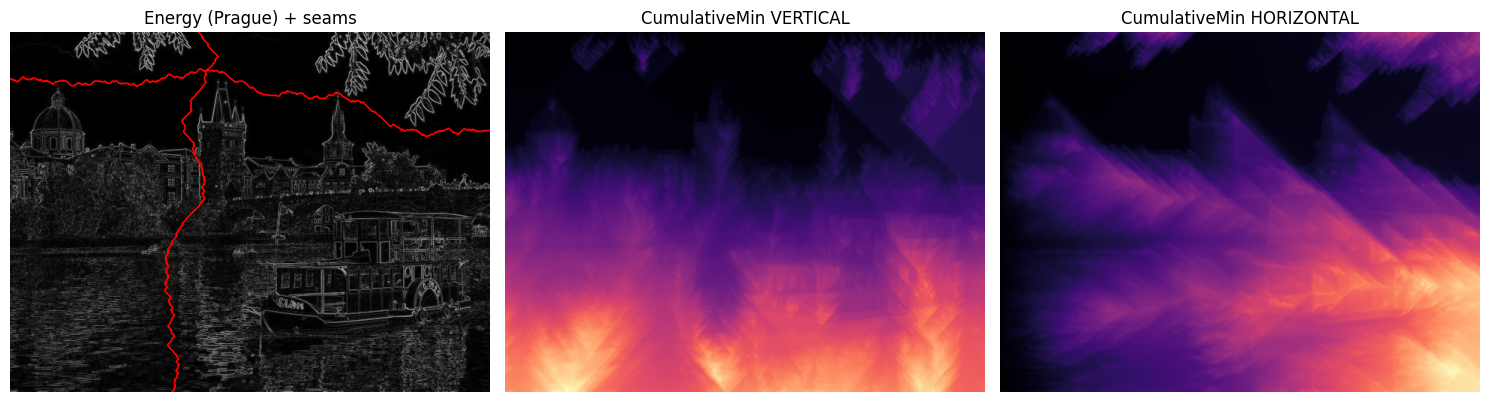

In [14]:
# --- Compute seams ---
v_seam = find_vertical_seam(CV_prague_v)       # indices of vertical seam (one per row)
h_seam = find_horizontal_seam(CV_prague_h)     # indices of horizontal seam (one per col)

# --- Plotting ---
fig, axs = plt.subplots(1,3, figsize=(15,5))

# Energy map with both vertical + horizontal seams
axs[0].imshow(E_prague, cmap='gray')
axs[0].plot(v_seam, range(E_prague.shape[0]), 'r', linewidth=1.2)      # vertical seam (red)
axs[0].plot(range(E_prague.shape[1]), h_seam, 'r', linewidth=1.2)      # horizontal seam (blue)
axs[0].set_title('Energy (Prague) + seams')
axs[0].axis('off')

# Vertical cumulative energy map (no seam overlay)
axs[1].imshow(CV_prague_v, cmap='magma')
axs[1].set_title('CumulativeMin VERTICAL')
axs[1].axis('off')

# Horizontal cumulative energy map (no seam overlay)
axs[2].imshow(CV_prague_h, cmap='magma')
axs[2].set_title('CumulativeMin HORIZONTAL')
axs[2].axis('off')

plt.tight_layout()
plt.show()


## Task 4 — Draw the first horizontal and vertical seams (Prague)

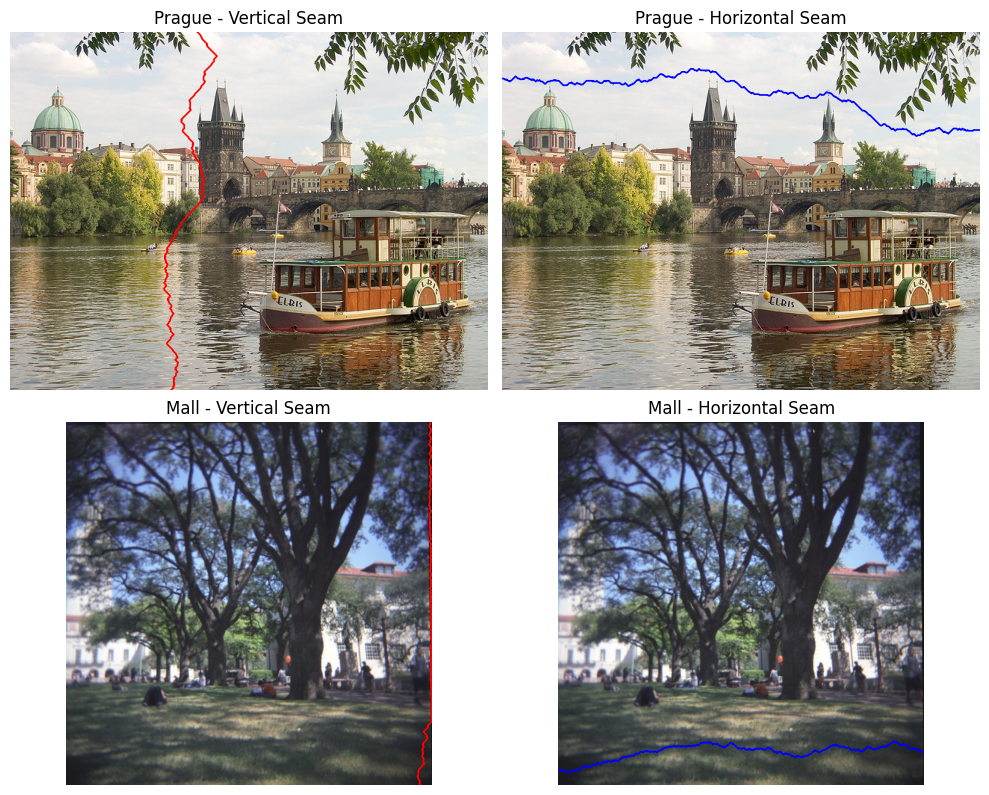

We can see a problem here when we don't implement the edge penalty.


In [ ]:
# --- Prague seams ---
seam_v_prague = find_vertical_seam(CV_prague_v)     # vertical seam for Prague
seam_h_prague = find_horizontal_seam(CV_prague_h)   # horizontal seam for Prague

# --- Mall seams ---
E_mall = energy_img(im_mall)                        # raw energy map (Mall)
CV_mall_v = cumulative_min_energy_map(E_mall, 'VERTICAL')
CV_mall_h = cumulative_min_energy_map(E_mall, 'HORIZONTAL')

seam_v_mall = find_vertical_seam(CV_mall_v)         # vertical seam for Mall
seam_h_mall = find_horizontal_seam(CV_mall_h)       # horizontal seam for Mall


# 2x2 grid plot 
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Prague vertical seam
axs[0,0].imshow(im_prague)
axs[0,0].plot(seam_v_prague, range(im_prague.shape[0]), 'r', linewidth=1.2)
axs[0,0].set_title("Prague - Vertical Seam")
axs[0,0].axis("off")

# Prague horizontal seam
axs[0,1].imshow(im_prague)
axs[0,1].plot(range(im_prague.shape[1]), seam_h_prague, 'b', linewidth=1.2)
axs[0,1].set_title("Prague - Horizontal Seam")
axs[0,1].axis("off")

# Mall vertical seam
axs[1,0].imshow(im_mall)
axs[1,0].plot(seam_v_mall, range(im_mall.shape[0]), 'r', linewidth=1.2)
axs[1,0].set_title("Mall - Vertical Seam")
axs[1,0].axis("off")

# Mall horizontal seam
axs[1,1].imshow(im_mall)
axs[1,1].plot(range(im_mall.shape[1]), seam_h_mall, 'b', linewidth=1.2)
axs[1,1].set_title("Mall - Horizontal Seam")
axs[1,1].axis("off")

plt.tight_layout()
plt.show()

print("We can see a problem here when we don't implement the edge penalty.")


## Task 5 — Modified energy (Prewitt + edge penalty)

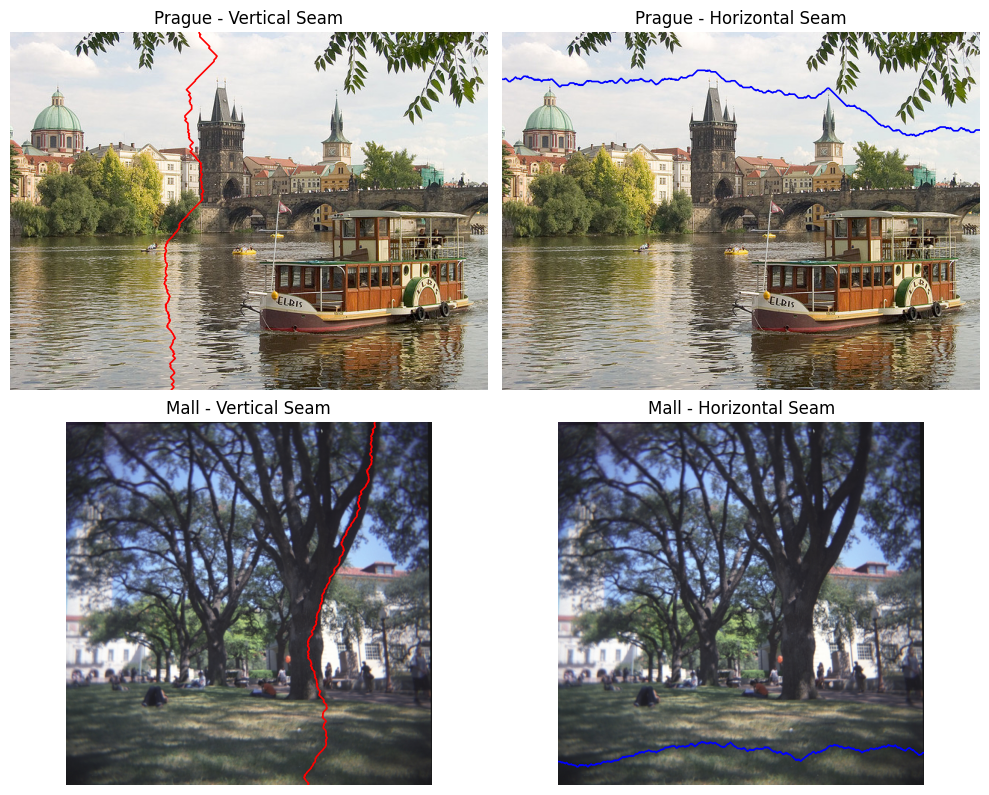

The vertical seam no longer sticks to the sides.


In [ ]:
# --- Prague (custom Prewitt + penalty) ---
E_prague_mod = energy_img_prewitt_custom(im_prague, w_vert=1.25, w_horz=1.0, apply_edge_penalty=True)
CV_prague_mod_v = cumulative_min_energy_map_local(E_prague_mod, 'VERTICAL')
CV_prague_mod_h = cumulative_min_energy_map_local(E_prague_mod, 'HORIZONTAL')

seam_v_prague_mod = _find_vertical_seam_from(CV_prague_mod_v)
seam_h_prague_mod = _find_horizontal_seam_from(CV_prague_mod_h)


# --- Mall (custom Prewitt + penalty) ---
E_mall_mod = energy_img_prewitt_custom(im_mall, w_vert=1.25, w_horz=1.0, apply_edge_penalty=True)
CV_mall_mod_v = cumulative_min_energy_map_local(E_mall_mod, 'VERTICAL')
CV_mall_mod_h = cumulative_min_energy_map_local(E_mall_mod, 'HORIZONTAL')

seam_v_mall_mod = _find_vertical_seam_from(CV_mall_mod_v)
seam_h_mall_mod = _find_horizontal_seam_from(CV_mall_mod_h)


# use fix and axis so we can make it prettier and assign to each subplot
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Prague vertical seam
axs[0,0].imshow(im_prague)
axs[0,0].plot(seam_v_prague_mod, range(im_prague.shape[0]), 'r', linewidth=1.2)
axs[0,0].set_title("Prague - Vertical Seam")
axs[0,0].axis("off")

# Prague horizontal seam
axs[0,1].imshow(im_prague)
axs[0,1].plot(range(im_prague.shape[1]), seam_h_prague_mod, 'b', linewidth=1.2)
axs[0,1].set_title("Prague - Horizontal Seam")
axs[0,1].axis("off")

# Mall vertical seam
axs[1,0].imshow(im_mall)
axs[1,0].plot(seam_v_mall_mod, range(im_mall.shape[0]), 'r', linewidth=1.2)
axs[1,0].set_title("Mall - Vertical Seam")
axs[1,0].axis("off")

# Mall horizontal seam
axs[1,1].imshow(im_mall)
axs[1,1].plot(range(im_mall.shape[1]), seam_h_mall_mod, 'b', linewidth=1.2)
axs[1,1].set_title("Mall - Horizontal Seam")
axs[1,1].axis("off")

plt.tight_layout()
plt.show()

print("The vertical seam no longer sticks to the sides.")


## Task 6 — Run on 3+ custom images vs standard resize

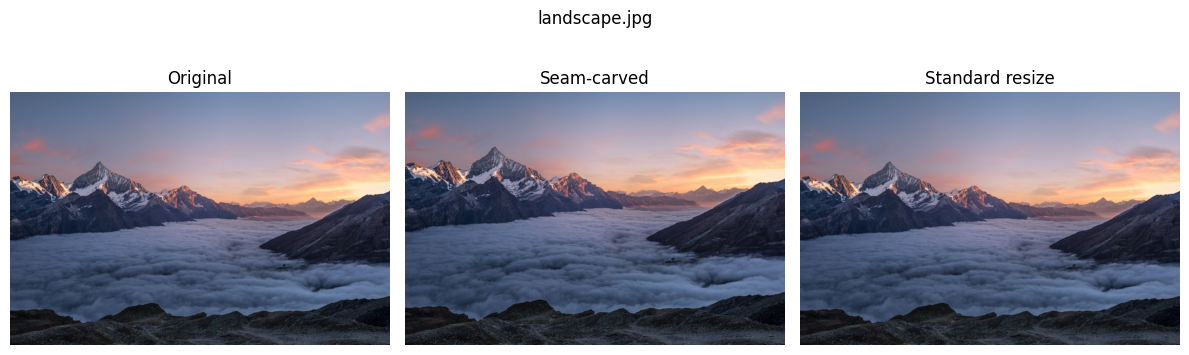

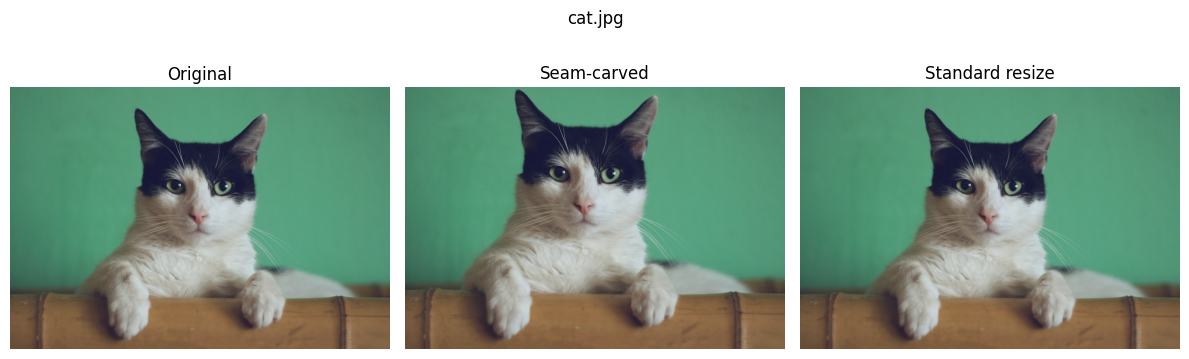

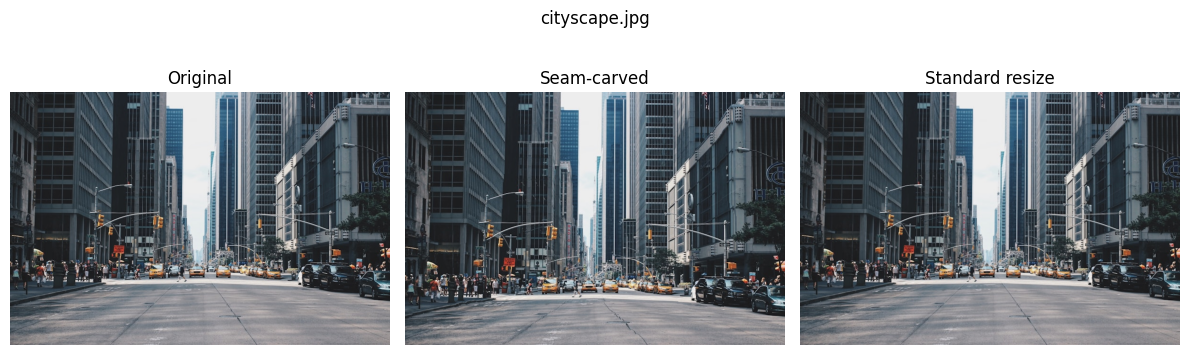

In [26]:
import urllib.request     # module to fetch files from the web (used for images)
os.makedirs('test_images', exist_ok=True)# make a folder named 'test_images' if it doesn’t exist yet

# list of test images: each entry is (URL of image, local save path)
test_urls = [
    ('https://images.unsplash.com/photo-1506905925346-21bda4d32df4', 'test_images/landscape.jpg'),
    ('https://images.unsplash.com/photo-1514888286974-6c03e2ca1dba', 'test_images/cat.jpg'),
    ('https://images.unsplash.com/photo-1449824913935-59a10b8d2000', 'test_images/cityscape.jpg'),
]

# loop over all the (url, filename) pairs
for url, fname in test_urls:            
    if not os.path.exists(fname):# if the file isn’t already downloaded
        urllib.request.urlretrieve(url, fname)# fetch it from the internet and save locally

custom_images = [f for _, f in test_urls]# extract only the filenames into a list

# demo function that performs seam carving vs standard resize and shows results
def seam_carve_demo(img_path, dw=60, dh=40):
    try:
        # load image as RGB, store as numpy array with dtype uint8 (0–255 per channel)
        im = np.array(Image.open(img_path).convert('RGB'), dtype=np.uint8)  
    except Exception as e:
        print(f'Skip {img_path}: {e}')  # if image fails to load, print error and skip
        return
    out = im.copy(); E = energy_img(out)# start with copy of input and compute initial energy map
    for _ in range(dw):# loop dw times (shrink width by dw pixels)
        out, E = decrease_width_baseline(out, E)# carve one vertical seam each iteration, update energy
    for _ in range(dh):  # loop dh times (shrink height by dh pixels)
        out, E = decrease_height_baseline(out, E)# carve one horizontal seam each iteration, update energy
    H, W = im.shape[:2]  # original height and width
    target = (W - dw, H - dh)# new dimensions after reduction
    # standard image resize (bicubic interpolation) to the same target size for comparison
    std = np.array(Image.fromarray(im).resize(target, resample=Image.BICUBIC))  
    fig, axs = plt.subplots(1,3, figsize=(12,4))# create side-by-side subplot: 1 row, 3 columns
    axs[0].imshow(im); axs[0].set_title('Original'); axs[0].axis('off')# show original
    axs[1].imshow(out); axs[1].set_title('Seam-carved'); axs[1].axis('off')# show seam-carved
    axs[2].imshow(std); axs[2].set_title('Standard resize'); axs[2].axis('off') # show regular resize
    plt.suptitle(os.path.basename(img_path)); plt.tight_layout(); plt.show()# add title + display plots

# run demo for all downloaded test images
for p in custom_images:
    seam_carve_demo(p, dw=60, dh=40)
  
# update the list to use your own local images sinstead of the test set
custom_images = []

# re-define demo function (same as above, works for your local images too)
def seam_carve_demo(img_path, dw=60, dh=40):  
    try:
        im = np.array(Image.open(img_path).convert('RGB'), dtype=np.uint8)
    except Exception as e:
        print(f'Skip {img_path}: {e}')# skip if image not found or unreadable
        return
    out = im.copy(); E = energy_img(out)# copy + compute energy
    for _ in range(dw):# shrink width dw pixels
        out, E = decrease_width_baseline(out, E)
    for _ in range(dh):# shrink height dh pixels
        out, E = decrease_height_baseline(out, E)
    H, W = im.shape[:2]
    target = (W - dw, H - dh)# new size
    std = np.array(Image.fromarray(im).resize(target, resample=Image.BICUBIC))# standard resize
    fig, axs = plt.subplots(1,3, figsize=(12,4))
    axs[0].imshow(im); axs[0].set_title('Original'); axs[0].axis('off')
    axs[1].imshow(out); axs[1].set_title('Seam-carved'); axs[1].axis('off')
    axs[2].imshow(std); axs[2].set_title('Standard resize'); axs[2].axis('off')
    plt.suptitle(os.path.basename(img_path)); plt.tight_layout(); plt.show()

# run demo on your custom images
for p in custom_images:
    seam_carve_demo(p, dw=60, dh=40)
